# **Importing Libraries**

In [ ]:
import pandas as pd
import spacy
import numpy as np
import requests
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import pickle
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Useful for debugging
tf.config.run_functions_eagerly(True)

In [ ]:
# Loading Spacy Large English language model
# designed for various NLP tasks such as entity recognition, part-of-speech tagging, word embeddings, etc.
nlp = spacy.load("en_core_web_lg")

# **Loading Dataset**

In [ ]:
train_df = pd.read_csv('/kaggle/input/cosmosqa/train.csv')  # FilePath for train data
val_df = pd.read_csv('/kaggle/input/cosmosqa/valid.csv')    # FilePath for validation data
test_df = pd.read_csv('/kaggle/input/cosmosqa/test.csv')    # FilePath for test data

# **Symbolic Part**

In [ ]:
# Takes text data as input and returns vector representation of the entire text using SpaCy's 'Large English language model'
def text_to_vector(text):
    text = str(text)
    return nlp(text).vector

Read the ConceptNet assertions from a CSV file and build an index (dictionary) mapping words to related terms

In [ ]:
# Memory size
chunk_size = 100000

# Path to ConceptNet knowledge base stored in a CSV file
conceptnet_csv_path = '/kaggle/input/conceptnet-assertions/assertions.csv'

# Empty dictionary to hold ConceptNet knowledge base
conceptnet_kb = {}

In [ ]:
# This function builds an index (conceptnet_kb) from a ConceptNet knowledge base stored in a CSV file,
# filtering for relations of type '/r/RelatedTo' and nodes starting with '/c/en'.
def build_conceptnet_index(csv_path, chunk_size):
    # Read the CSV file in chunks using pandas with a specified chunk size (memory size).
    reader = pd.read_csv(csv_path, header=None, sep='\t', chunksize=chunk_size)

    # Iterate through each chunk and filter rows based on relation type and node prefixes.
    for chunk in reader:
        chunk = chunk[chunk[1].str.contains('/r/RelatedTo') & chunk[2].str.startswith('/c/en') & chunk[3].str.startswith('/c/en')]

        # Iterate through filtered rows in the chunk and update the conceptnet_kb dictionary.
        for i, row in chunk.iterrows():
            start = row[2].split('/')[3]
            end = row[3].split('/')[3]
            if start not in conceptnet_kb:
                conceptnet_kb[start] = set()
            conceptnet_kb[start].add(end)


Retrieve related terms for a given word from the ConceptNet knowledge base

In [ ]:
# This function takes a lowercase word as input,
# retrieves its related terms from a ConceptNet knowledge base stored in conceptnet_kb,
# and returns them as a space-separated string.
def get_conceptnet_knowledge(word):
    word = word.lower()
    related_terms = conceptnet_kb.get(word, set())
    return ' '.join(related_terms)

In [ ]:
# Call build_conceptnet_index function to update the dictionary
build_conceptnet_index(conceptnet_csv_path, chunk_size)

### **Data Preprocessing**

In [ ]:
def preprocess_data(df):
    # Compute spaCy vector representations for context, question, and answer components by calling the text_to_vector function.
    context_vecs = df['context'].apply(text_to_vector)
    question_vecs = df['question'].apply(text_to_vector)
    answer_vecs = [df[f'answer{i}'].apply(text_to_vector) for i in range(4)]
    labels = df['label'].values

    # Extract ConceptNet knowledge for each context ending and compute corresponding spaCy vector representations.
    context_knowledge = df['context'].apply(lambda x: get_conceptnet_knowledge(x.split()[-1]))
    context_knowledge_vecs = context_knowledge.apply(text_to_vector)

    # Return the processed vectors and labels for further use in a machine learning model.
    return context_vecs, question_vecs, context_knowledge_vecs, answer_vecs, labels


In [ ]:
# Calling preprocess_data function
train_context, train_question, train_context_knowledge, train_answers, train_labels = preprocess_data(train_df)

# **Neural Network Part**

Bi-directional LSTM

In [ ]:
def build_model(input_shape, num_classes):
    # Input layer
    model_input = Input(shape=input_shape, dtype='float32', name='model_input')

    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(256, return_sequences=True,
                               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                               bias_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(model_input)
    dropout1 = Dropout(0.3)(lstm1)
    batch_norm1 = BatchNormalization()(dropout1)

    lstm2 = Bidirectional(LSTM(128,
                               kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4),
                               bias_regularizer=l1_l2(l1=1e-5, l2=1e-4)))(batch_norm1)
    dropout2 = Dropout(0.3)(lstm2)
    batch_norm2 = BatchNormalization()(dropout2)

    dense_intermediate = Dense(64, activation='relu')(batch_norm2)
    dropout_final = Dropout(0.3)(dense_intermediate)

    output = Dense(num_classes, activation='softmax')(dropout_final)


    model = Model(inputs=model_input, outputs=output)

    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


num_classes = 4
input_shape = (7, 300)
model = build_model(input_shape, num_classes)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 7, 300)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 7, 512)           1140736   
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 512)            0         
                                                                 
 batch_normalization (BatchN  (None, 7, 512)           2048      
 ormalization)                                                   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                             

In [ ]:
# Early stopping callback to monitor validation loss, halt training if no improvement after 10 epochs, and restore best weights.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Reduce learning rate on plateau callback to adjust learning rate by a factor of 0.2 if no improvement in validation loss after 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

In [ ]:
# Combining all the columns into one array
train_data = [train_context, train_question, train_context_knowledge] + train_answers

# Converting it into tensor
train_data_tensor_reshaped = tf.convert_to_tensor(train_data, dtype=tf.float32)

# Converting it into numpy for reshaping into the required dimensions
train_data_numpy = train_data_tensor_reshaped.numpy()
train_data_numpy_reshaped = np.reshape(train_data_numpy, (25262, 7, 300))

In [ ]:
# Finally converting into tensor
train_data_tensor = tf.convert_to_tensor(train_data_numpy_reshaped, dtype=tf.float32)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.float32)

Model Training

In [ ]:
history = model.fit(train_data_tensor, train_labels_tensor,
                    validation_split = 0.2,
                    epochs=200,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/200
316/316 [==============================] - 57s 166ms/step - loss: 2.4642 - accuracy: 0.2520 - val_loss: 2.1203 - val_accuracy: 0.2537 - lr: 1.0000e-04
Epoch 2/200
316/316 [==============================] - 53s 166ms/step - loss: 2.2818 - accuracy: 0.2619 - val_loss: 2.1092 - val_accuracy: 0.2535 - lr: 1.0000e-04
Epoch 3/200
316/316 [==============================] - 53s 167ms/step - loss: 2.2065 - accuracy: 0.2629 - val_loss: 2.0936 - val_accuracy: 0.2484 - lr: 1.0000e-04
Epoch 4/200
316/316 [==============================] - 52s 165ms/step - loss: 2.1564 - accuracy: 0.2707 - val_loss: 2.0814 - val_accuracy: 0.2529 - lr: 1.0000e-04
Epoch 5/200
316/316 [==============================] - 53s 167ms/step - loss: 2.1251 - accuracy: 0.2669 - val_loss: 2.0703 - val_accuracy: 0.2565 - lr: 1.0000e-04
Epoch 6/200
316/316 [==============================] - 53s 167ms/step - loss: 2.0976 - accuracy: 0.2741 - val_loss: 2.0601 - val_accuracy: 0.2517 - lr: 1.0000e-04
Epoch 7/200
316/316 [=

In [ ]:
# Saving the trained model
pickle.dump(model, open('model_saved.pkl', 'wb'))

Accuracy Plot

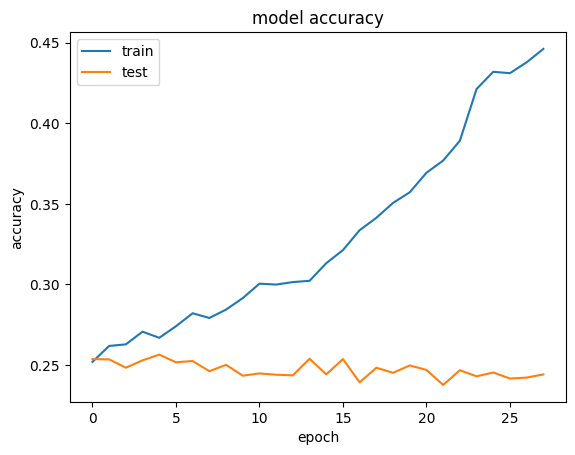

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss Plot

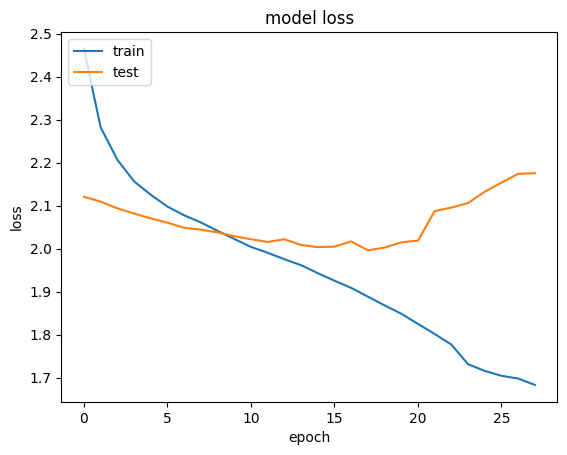

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()